In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Dense, Dropout, LSTM, Flatten, Bidirectional, TextVectorization, Activation
from keras.models import Sequential, load_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras.metrics import AUC
import tensorflow as tf

import spacy
from nltk.stem import PorterStemmer

from gensim.models import word2vec

import src.helpers.data_helpers as dth

### Chargement des données

In [2]:
# Charger les données depuis le fichier csv
data = pd.read_csv('data/training.1600000.processed.noemoticon.csv', sep=',', encoding = "ISO-8859-1", header=None, names=['target', 'id', 'date', 'flag', 'user', 'text'])

# Ne garder que les colonnes nécessaires
data = data[["text", "target"]]

# On supprime les tweets en doublons
data.drop_duplicates(subset=['text'], inplace=True)

# Remplacer les valeurs par les vrais labels
data['target'] = data['target'].map(
    {
        0: "NEGATIF",
        4: "POSITIF"
    }
)

# Binarize target
data['target'] = data['target'].map(
    {
        "NEGATIF": 0,
        "POSITIF": 1,
    }
)

data.describe()

,target
count,1.581466e+06
mean,5.003465e-01
std,5.000000e-01
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


In [5]:
data['text'][1]

"is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"

### Modèle simple avec lemmatisation / stemming et embedding Word2Vec / Glove

In [37]:
# sampling data
sample_positif = data[data["target"] == 1].sample(n = 20000)
sample_negatif = data[data["target"] == 0].sample(n = 20000)

sample = pd.concat([sample_negatif, sample_positif])

X = sample['text']
y = sample['target']

In [38]:
type(X)

pandas.core.series.Series

In [20]:
nlp = spacy.load('en_core_web_sm')

all_stopwords = nlp.Defaults.stop_words

# Ajout / Suppression de stop words
all_stopwords.add('re')
if 'not' in all_stopwords:
    all_stopwords.remove('not')

In [21]:
X_lemma = [[token.lemma_.lower() for token in doc if token.is_alpha and token.lemma_.lower() not in all_stopwords] for doc in nlp.pipe(X)]

In [9]:
ps = PorterStemmer()

X_stemm = [[ps.stem(token.text) for token in doc if token.is_alpha and token.text.lower() not in all_stopwords] for doc in nlp.pipe(X)]

In [22]:
X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(X_lemma, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
X_train_stemm, X_test_stemm, y_train_stemm, y_test_stemm = train_test_split(X_stemm, y, test_size=0.2, stratify=y, random_state=42)

In [23]:
emmbed_dict = {}
with open('data/glove.twitter.27B.200d.txt', 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        emmbed_dict[word] = vector

print(f'Il y a {len(emmbed_dict)} mots vectorisés')

Il y a 1193514 mots vectorisés


In [12]:
def createEmbeddingLayerWord2Vec(tokenizer, X_train):
    w2v_model = word2vec.Word2Vec(vector_size=300, min_count=5)

    w2v_model.build_vocab(X_train)

    w2v_model.train(X_train, total_examples=w2v_model.corpus_count, epochs=32)

    vocab_size = len(tokenizer.word_index) + 1

    embedding_matrix = np.zeros((vocab_size, 300))

    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv.index_to_key:
            embedding_matrix[i] = w2v_model.wv.get_vector(word, norm=True)

    return Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

def createEmbeddingLayerGlove(tokenizer, emmbed_dict):

    vocab_size = len(tokenizer.word_index) + 1

    embedding_matrix = np.zeros((vocab_size, 200))

    for word, i in tokenizer.word_index.items():
        embedding_vector = emmbed_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=200, trainable=False)

In [24]:
tokenizer_lemma = Tokenizer()
tokenizer_lemma.fit_on_texts(X_train_lemma)

#tokenizer_stemm = Tokenizer()
#tokenizer_stemm.fit_on_texts(X_train_stemm)

def tokenize_data(data,tokenizer,maxlen=None):
    X = tokenizer.texts_to_sequences(data)
    return pad_sequences(X,maxlen=maxlen)

In [13]:
def trainModel(model_name, embedding_layer, X_train, y_train, X_test, y_test, embedding_dim, tokenizer):

    x_train = tokenize_data(X_train,tokenizer,maxlen=embedding_dim)
    x_test = tokenize_data(X_test,tokenizer,maxlen=embedding_dim)

    model_path = os.path.join('models', model_name)

    if os.path.exists(model_path):
        model = load_model(model_path)

    else:
        # Create LSTM Model
        model = Sequential(name=model_name)
        model.add(embedding_layer)
        model.add(LSTM(256))

        # Classification layer
        model.add(Dense(1, activation='sigmoid'))

        # Compile
        model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ["AUC","accuracy"])

        print(model.summary())

        # Train
        model.fit(x_train, y_train, validation_split=0.2, epochs = 2)

        # Save the model
        model.save(model_path)

    y_test_pred_proba = model.predict(
        x_test,
        batch_size=128,
        workers=4,
        use_multiprocessing=True,
    )

    y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

    print(f"Resultats modèle : {model_name}")

    dth.plot_classifier_results(model, x_test, y_test, y_test_pred, y_test_pred_proba)

Resultats modèle : stemm_word2vec_lstm


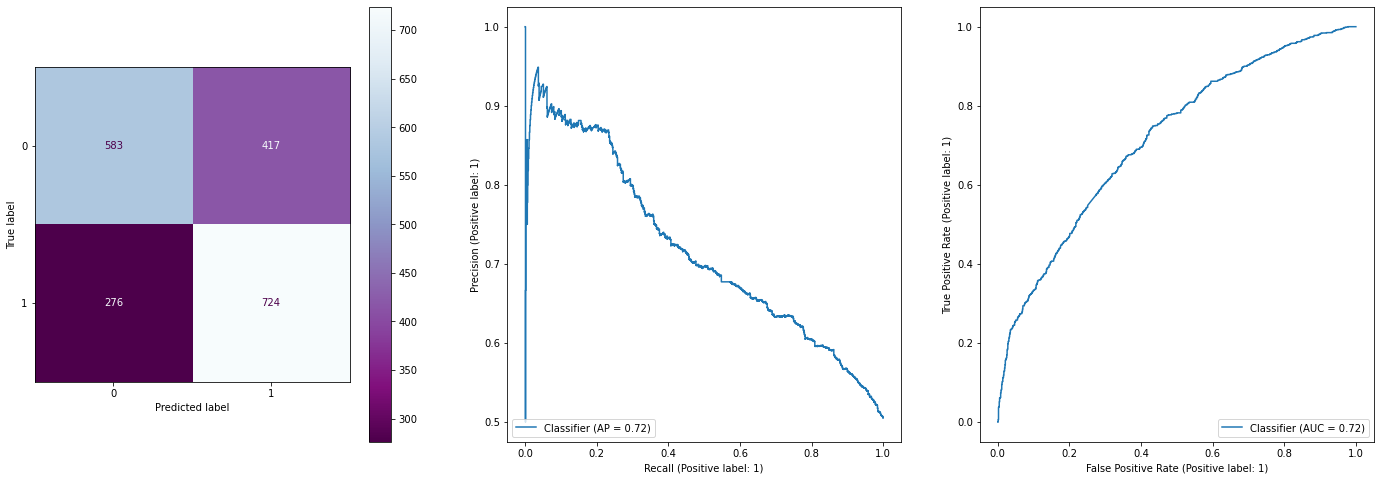

Resultats modèle : lemma_word2vec_lstm


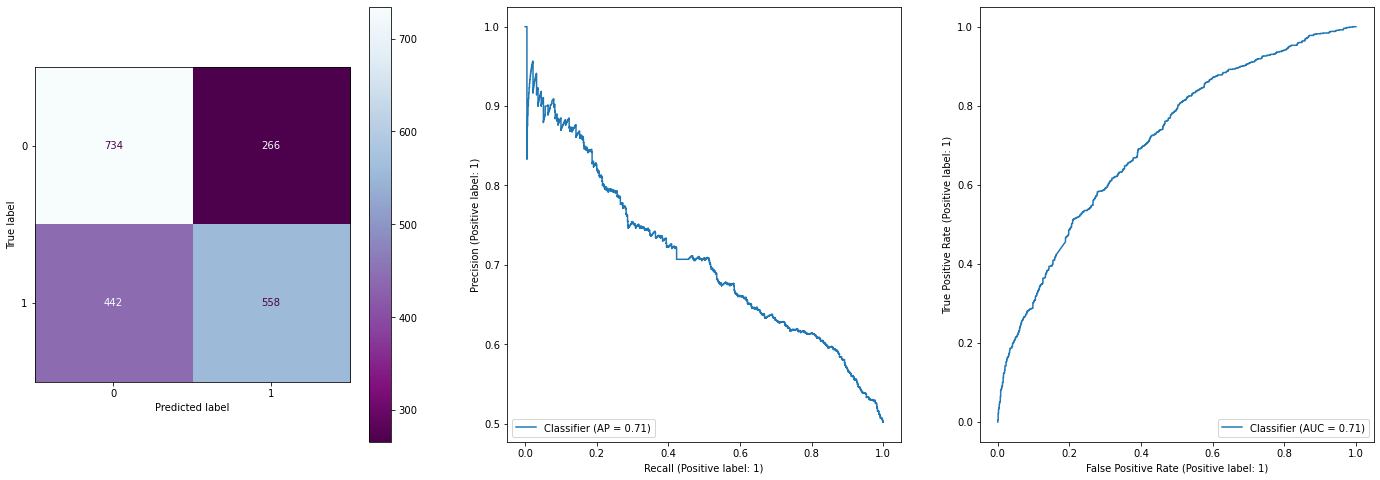

Resultats modèle : stemm_glove_lstm


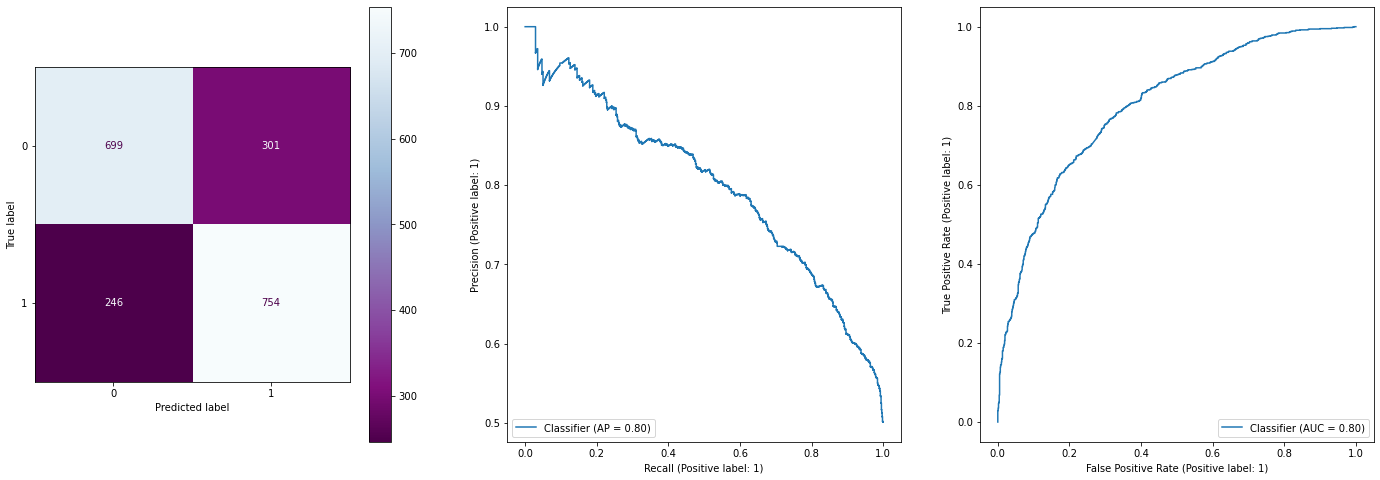

Resultats modèle : lemma_glove_lstm


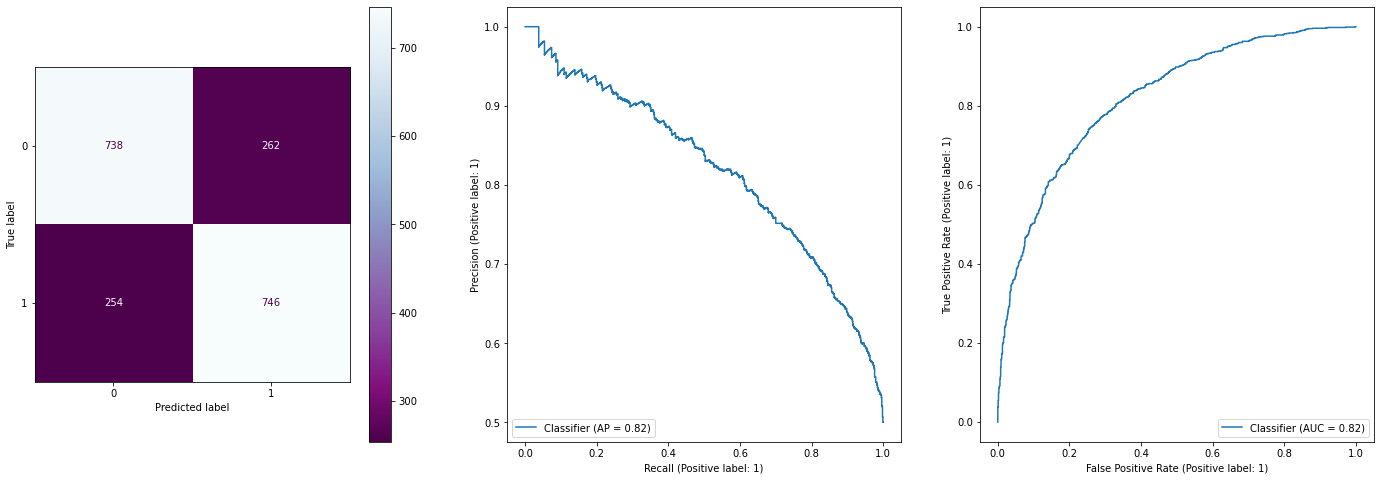

In [17]:
trainModel('stemm_word2vec_lstm', createEmbeddingLayerWord2Vec(tokenizer_stemm, X_train_stemm), X_train_stemm, y_train_stemm, X_test_stemm, y_test_stemm, 300, tokenizer_stemm)

trainModel('lemma_word2vec_lstm', createEmbeddingLayerWord2Vec(tokenizer_lemma, X_train_lemma), X_train_lemma, y_train_lemma, X_test_lemma, y_test_lemma, 300, tokenizer_lemma)

trainModel('stemm_glove_lstm', createEmbeddingLayerGlove(tokenizer_stemm, emmbed_dict), X_train_stemm, y_train_stemm, X_test_stemm, y_test_stemm, 200, tokenizer_stemm)

trainModel('lemma_glove_lstm', createEmbeddingLayerGlove(tokenizer_lemma, emmbed_dict), X_train_lemma, y_train_lemma, X_test_lemma, y_test_lemma, 200, tokenizer_lemma)

### SUITE modèles

In [34]:
# sampling data
sample_positif_2 = data[data["target"] == 1].sample(n = 20000)
sample_negatif_2 = data[data["target"] == 0].sample(n = 20000)

sample = pd.concat([sample_negatif_2, sample_positif_2])

X_2 = sample['text']
y_2 = sample['target']

ValueError: a must be greater than 0 unless no samples are taken

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_2,
    y_2,
    test_size=0.2,
    stratify=y_2,
    random_state=42,
)

In [6]:
model_name = "ffnn_on_count"
vocabulary_size = 10000

# Define vectorizer
vectorize_layer = TextVectorization(
        output_mode="count",
        max_tokens=vocabulary_size,
        pad_to_max_tokens=True,
    )
vectorize_layer.adapt(
        X_2,
        batch_size=128,
    )

# define NN model
model = Sequential(name=model_name)
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(Dense(100, input_shape=(vocabulary_size,), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

# compile NN network
model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
            AUC(curve="ROC", name="ROC_AUC"),
            AUC(curve="PR", name="AP"),
        ],
    )

# fit NN model
model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2),
        ],
        workers=4,
        use_multiprocessing=True,
    )

Epoch 1/10
200/200 [==============================] - 4s 13ms/step - loss: 0.5651 - accuracy: 0.7211 - ROC_AUC: 0.7886 - AP: 0.7763 - val_loss: 0.4970 - val_accuracy: 0.7709 - val_ROC_AUC: 0.8451 - val_AP: 0.8424
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 0.4274 - accuracy: 0.8093 - ROC_AUC: 0.8860 - AP: 0.8840 - val_loss: 0.4798 - val_accuracy: 0.7742 - val_ROC_AUC: 0.8522 - val_AP: 0.8486
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 0.3433 - accuracy: 0.8534 - ROC_AUC: 0.9286 - AP: 0.9299 - val_loss: 0.5050 - val_accuracy: 0.7727 - val_ROC_AUC: 0.8466 - val_AP: 0.8399
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2596 - accuracy: 0.8955 - ROC_AUC: 0.9602 - AP: 0.9614 - val_loss: 0.5550 - val_accuracy: 0.7634 - val_ROC_AUC: 0.8395 - val_AP: 0.8317


In [7]:
y_test_pred_proba_2 = model.predict(
    X_test,
    batch_size=128,
    workers=4,
    use_multiprocessing=True,
)

y_test_pred_2 = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_2]

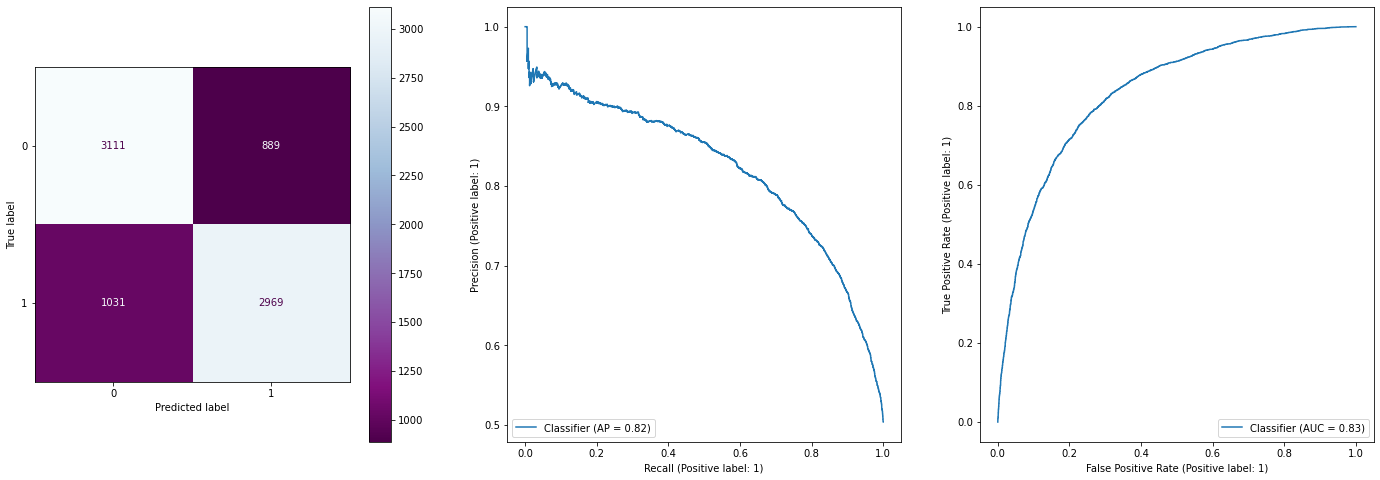

In [8]:
dth.plot_classifier_results(model, X_test, y_test, y_test_pred_2, y_test_pred_proba_2)

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_2,
    y_2,
    test_size=0.2,
    stratify=y_2,
    random_state=42,
)

In [9]:
model_name = "bidirectional_lstm"
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

# Define vectorizer
vectorize_layer = TextVectorization(
        output_mode="int",
        max_tokens=max_features,
        output_sequence_length=sequence_length,
    )
vectorize_layer.adapt(
        X_2,
        batch_size=128,
    )

# define NN model
model = Sequential(name=model_name)
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

# Embedding layer
model.add(
        Embedding(
            max_features,
            embedding_dim,
            input_length=sequence_length,
        )
    )

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=rnn_units, dropout=0.2)))

# Dense layers
model.add(Dense(100, input_shape=(max_features,), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation="relu"))

# Classification layer
model.add(Dense(1, activation="sigmoid"))

# compile NN network
model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
            AUC(curve="ROC", name="ROC_AUC"),
            AUC(curve="PR", name="AP"),
        ],
    )

# fit NN model
model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2),
        ],
        workers=4,
        use_multiprocessing=True,
    )

Epoch 1/10
200/200 [==============================] - 20s 83ms/step - loss: 0.5709 - accuracy: 0.6957 - ROC_AUC: 0.7712 - AP: 0.7678 - val_loss: 0.4768 - val_accuracy: 0.7777 - val_ROC_AUC: 0.8564 - val_AP: 0.8558
Epoch 2/10
200/200 [==============================] - 19s 96ms/step - loss: 0.4344 - accuracy: 0.8026 - ROC_AUC: 0.8807 - AP: 0.8801 - val_loss: 0.4724 - val_accuracy: 0.7803 - val_ROC_AUC: 0.8563 - val_AP: 0.8543
Epoch 3/10
200/200 [==============================] - 19s 94ms/step - loss: 0.3761 - accuracy: 0.8359 - ROC_AUC: 0.9121 - AP: 0.9135 - val_loss: 0.5049 - val_accuracy: 0.7694 - val_ROC_AUC: 0.8511 - val_AP: 0.8468
Epoch 4/10
200/200 [==============================] - 20s 98ms/step - loss: 0.3201 - accuracy: 0.8625 - ROC_AUC: 0.9371 - AP: 0.9395 - val_loss: 0.5431 - val_accuracy: 0.7638 - val_ROC_AUC: 0.8426 - val_AP: 0.8354


In [117]:
y_test_pred_proba = model.predict(
    X_test,
    batch_size=128,
    workers=4,
    use_multiprocessing=True,
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

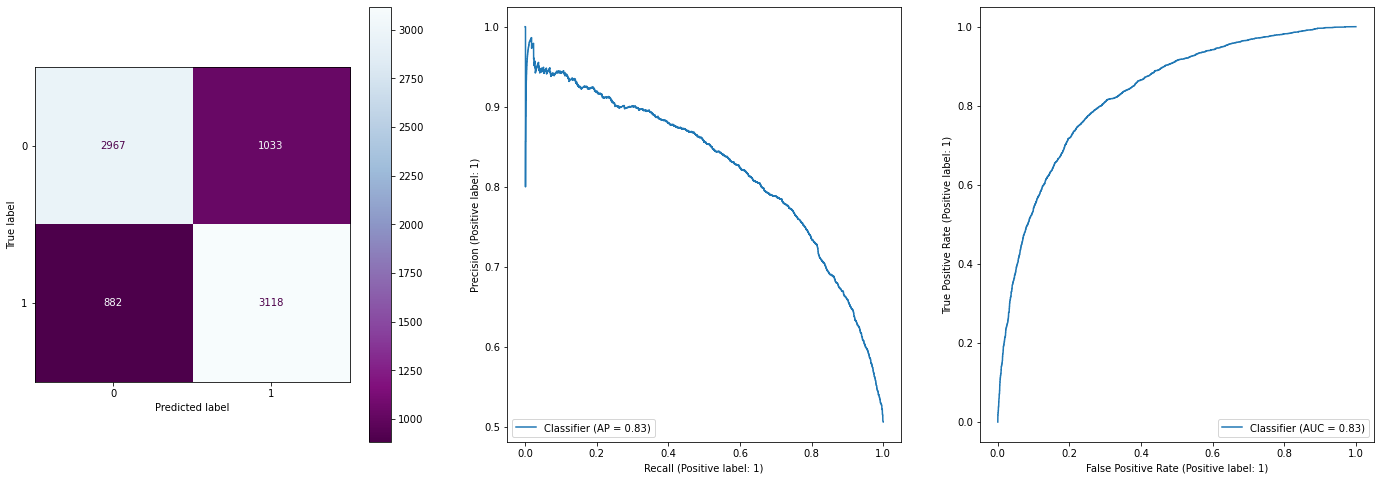

In [13]:
dth.plot_classifier_results(model, X_test, y_test, y_test_pred, y_test_pred_proba)

Epoch 1/10
200/200 [==============================] - 233s 1s/step - loss: 0.5627 - auc: 0.7809 - accuracy: 0.7088 - val_loss: 0.5186 - val_auc: 0.8211 - val_accuracy: 0.7409
Epoch 2/10
200/200 [==============================] - 237s 1s/step - loss: 0.5157 - auc: 0.8235 - accuracy: 0.7436 - val_loss: 0.5068 - val_auc: 0.8302 - val_accuracy: 0.7461
Epoch 3/10
200/200 [==============================] - 245s 1s/step - loss: 0.4990 - auc: 0.8360 - accuracy: 0.7553 - val_loss: 0.5106 - val_auc: 0.8304 - val_accuracy: 0.7475
Epoch 4/10
200/200 [==============================] - 250s 1s/step - loss: 0.4874 - auc: 0.8444 - accuracy: 0.7617 - val_loss: 0.5013 - val_auc: 0.8332 - val_accuracy: 0.7486
Epoch 5/10
200/200 [==============================] - 236s 1s/step - loss: 0.4750 - auc: 0.8530 - accuracy: 0.7701 - val_loss: 0.5033 - val_auc: 0.8362 - val_accuracy: 0.7489
Epoch 6/10
200/200 [==============================] - 246s 1s/step - loss: 0.4606 - auc: 0.8626 - accuracy: 0.7773 - val_loss

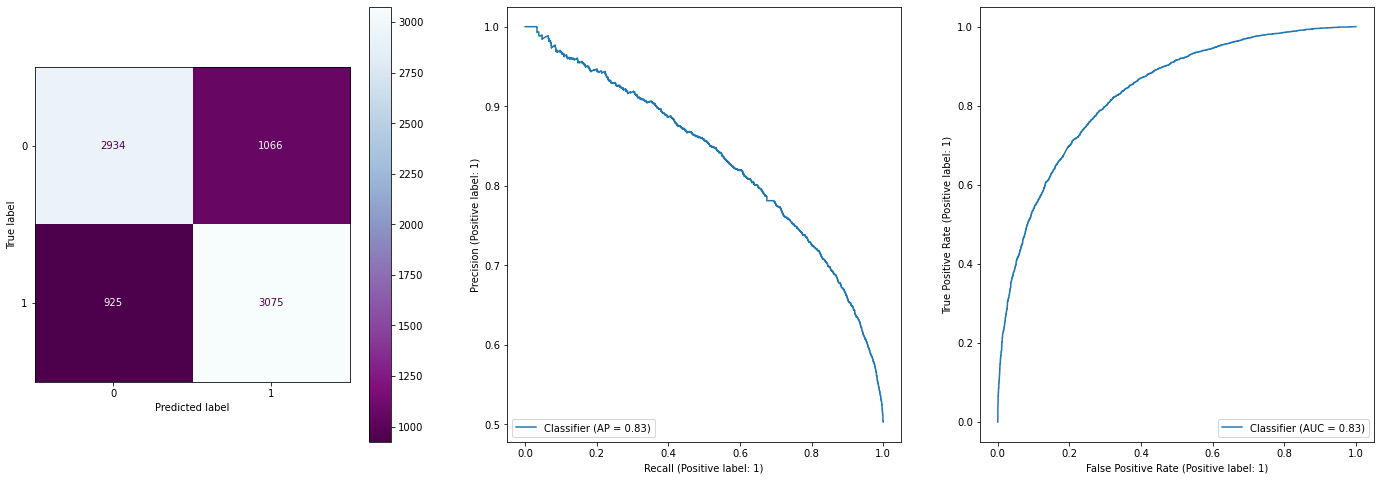

In [25]:
embedding_layer = createEmbeddingLayerGlove(tokenizer_lemma, emmbed_dict)

x_train_lemma = tokenize_data(X_train_lemma, tokenizer_lemma, maxlen=200)
x_test_lemma = tokenize_data(X_test_lemma, tokenizer_lemma, maxlen=200)

model_name = "bidirectional_lstm"
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

# define NN model
model = Sequential(name=model_name)
model.add(embedding_layer)

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=rnn_units, dropout=0.2)))

# Dense layers
model.add(Dense(100, input_shape=(max_features,), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation="relu"))

# Classification layer
model.add(Dense(1, activation="sigmoid"))

# compile NN network
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ["AUC","accuracy"])

# fit NN model
model.fit(
        x_train_lemma,
        y_train_lemma,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2),
        ],
        workers=4,
        use_multiprocessing=True,
    )

y_test_pred_proba = model.predict(
        x_test_lemma,
        batch_size=128,
        workers=4,
        use_multiprocessing=True,
    )

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

print(f"Resultats modèle : {model_name}")

dth.plot_classifier_results(model, x_test_lemma, y_test_lemma, y_test_pred, y_test_pred_proba)

In [16]:
# sampling data
sample_positif = data[data["target"] == 1].sample(n = 5000)
sample_negatif = data[data["target"] == 0].sample(n = 5000)

sample = pd.concat([sample_negatif, sample_positif])

X = sample['text']
y = sample['target']

In [59]:
X_cleaned= pd.Series(" ".join([token.text.lower() for token in doc if token.is_alpha and token.text.lower() not in all_stopwords]) for doc in nlp.pipe(X))

In [62]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

In [63]:
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at C:\Users\romai/.cache\huggingface\transformers\45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at C:\Users\romai/.cache\huggingface\transformers\c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\romai/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005b

In [64]:
max_len = 0

for tweet in X_cleaned:
    max_len = max(max_len, len(tweet))

print('Max tweet length: ', max_len)

Max tweet length:  117


In [78]:
def mask_inputs_for_bert(tweets, max_len):
    input_ids = []
    attention_masks = []

    for tweet in tweets:
        encoded_dict = tokenizer.encode_plus(
            tweet,
            add_special_tokens = True,
            max_length = max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask = True
        )
    
        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    
    return input_ids, attention_masks

In [79]:
train_inp, train_mask = mask_inputs_for_bert(X_train, max_len)
test_inp, test_mask = mask_inputs_for_bert(X_test, max_len)
train_label = tf.convert_to_tensor(y_train)
test_label = tf.convert_to_tensor(y_test)

In [82]:
print("Train_input shape", train_inp.shape)
print("Train_mask shape", train_mask.shape)
print("Test_input shape", test_inp.shape)
print("Test_mask shape", test_mask.shape)
print("Train_label shape", train_label.shape)
print("Test_label shape", test_label.shape)

Train_input shape (8000, 117)
Train_mask shape (8000, 117)
Test_input shape (2000, 117)
Test_mask shape (2000, 117)
Train_label shape (8000,)
Test_label shape (2000,)


In [52]:
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\romai/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

https://huggingface.co/bert-base-uncased/resolve/main/tf_model.h5 not found in cache or force_d

In [87]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

bert_model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=[metric])

In [88]:

bert_model.fit(
        [train_inp, train_mask],
        train_label,
        epochs=10,
        batch_size=128,
        validation_data=([test_inp, test_mask], test_label),
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2),
        ],
        workers=4,
        use_multiprocessing=True,
    )

Epoch 1/10
63/63 [==============================] - 7391s 117s/step - loss: 0.6079 - accuracy: 0.6647 - val_loss: 0.5213 - val_accuracy: 0.7530
Epoch 2/10
63/63 [==============================] - 7304s 116s/step - loss: 0.4906 - accuracy: 0.7731 - val_loss: 0.5068 - val_accuracy: 0.7605
Epoch 3/10
63/63 [==============================] - 7157s 114s/step - loss: 0.4128 - accuracy: 0.8189 - val_loss: 0.5141 - val_accuracy: 0.7605
Epoch 4/10
63/63 [==============================] - 7335s 117s/step - loss: 0.3248 - accuracy: 0.8684 - val_loss: 0.6142 - val_accuracy: 0.7460


In [96]:
y_test_pred_proba = bert_model([test_inp, test_mask])

In [101]:
prediction_logits = y_test_pred_proba[0]

In [102]:
prediction_probs = tf.nn.softmax(prediction_logits,axis=1).numpy()

In [134]:
prediction_probs_bis = []

for element in prediction_probs:
    prediction_probs_bis.append(element[1])

In [135]:
y_test_pred = [round(pred_proba) for pred_proba in prediction_probs_bis]

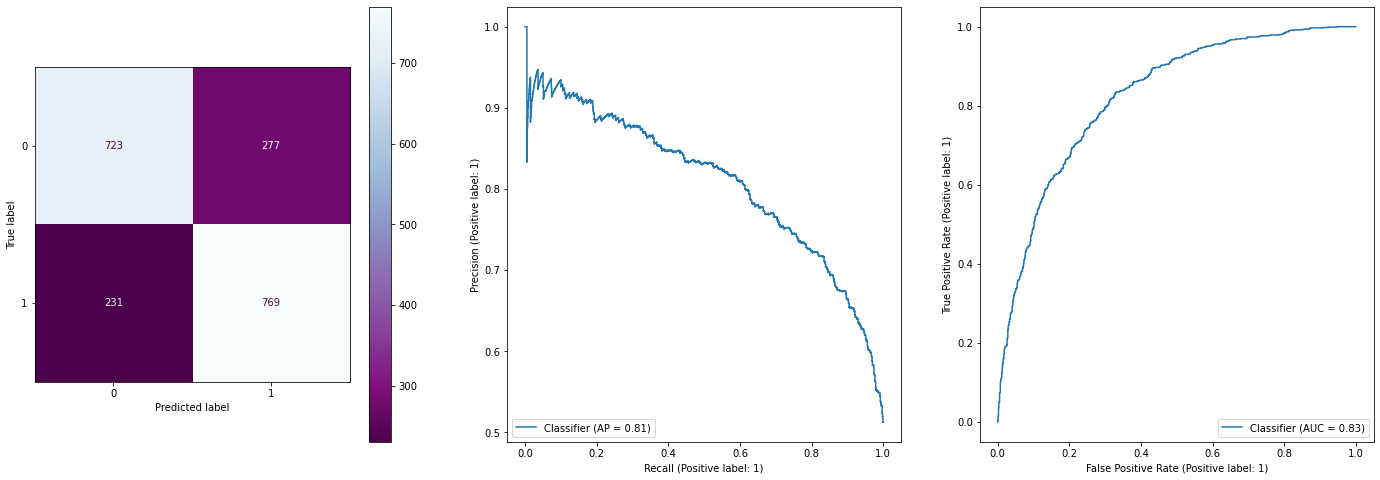

In [136]:
dth.plot_classifier_results(bert_model, [test_inp, test_mask], y_test, y_test_pred, prediction_probs_bis)